In [43]:
import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR, ExponentialLR

import torchvision
from torchvision.models import resnet18, ResNet18_Weights, mobilenet_v3_small, MobileNet_V3_Small_Weights
from torchvision import transforms

from sklearn.model_selection import train_test_split
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from IPython.display import clear_output
%matplotlib inline

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [3]:
# разделим картинки на train и val в отношении 70 на 30 для каждого класса
data_dir = "./the-simpsons-characters-dataset/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]

train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)

print(
    f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}"
)

Изображений в train: 14653
Изображений в val: 6280


In [4]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [5]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [6]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [7]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    scheduler=None
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        if scheduler is not None:
            scheduler.step() 
        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        if scheduler is not None:
            print(f'LR = {scheduler.get_last_lr()[0]:.6f}')
        
        plot_learning_curves(history)
        
    return model, history

In [8]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

## Тестирование schedulers

Epoch 3 of 3 took 87.814s
  training loss (in-iteration): 	2.143620
  validation loss (in-iteration): 	1.889031
  training accuracy: 			48.82 %
  validation accuracy: 			57.09 %
LR = 0.007290


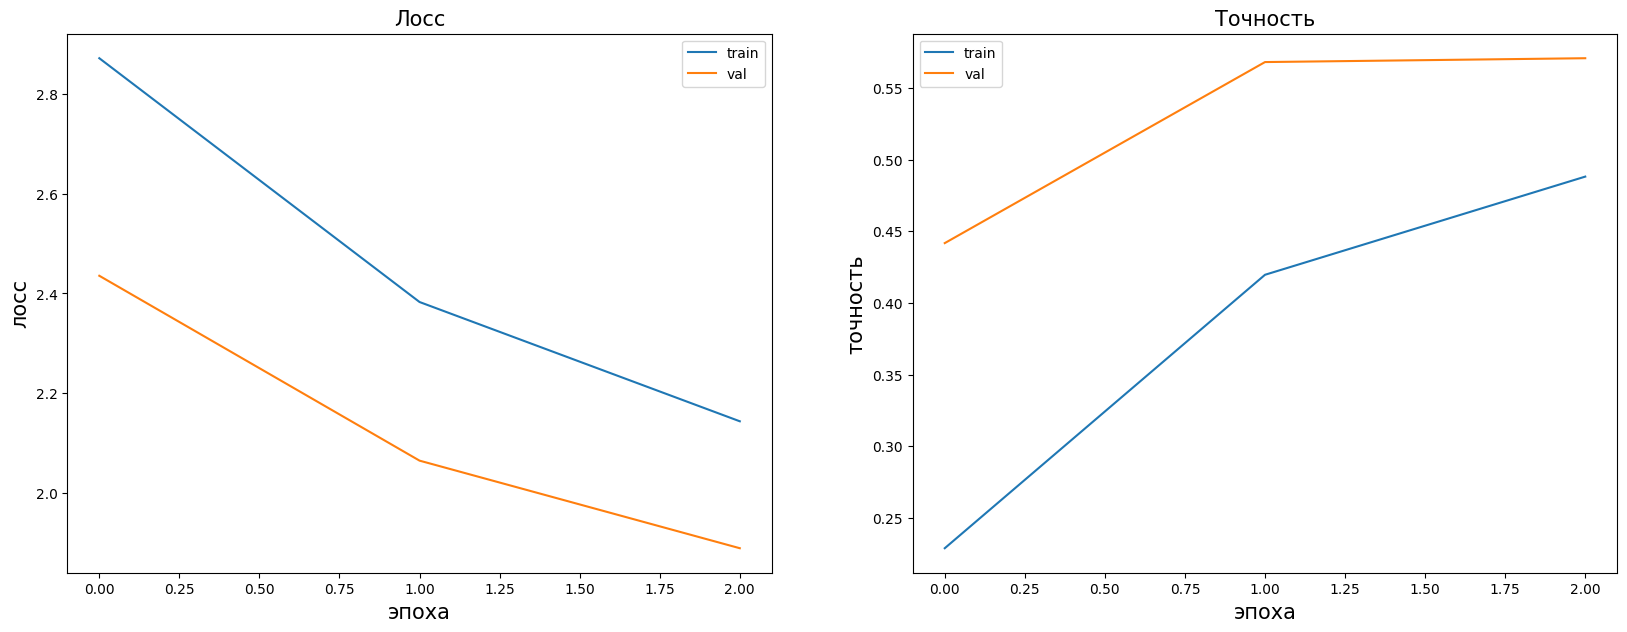

In [52]:
# возьмём предобученную сеть
fe_model = resnet18(weights=ResNet18_Weights.DEFAULT)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    fe_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=3, scheduler
)

Epoch 4 of 4 took 84.546s
  training loss (in-iteration): 	1.779075
  validation loss (in-iteration): 	1.556624
  training accuracy: 			56.96 %
  validation accuracy: 			63.70 %
LR = 0.005905


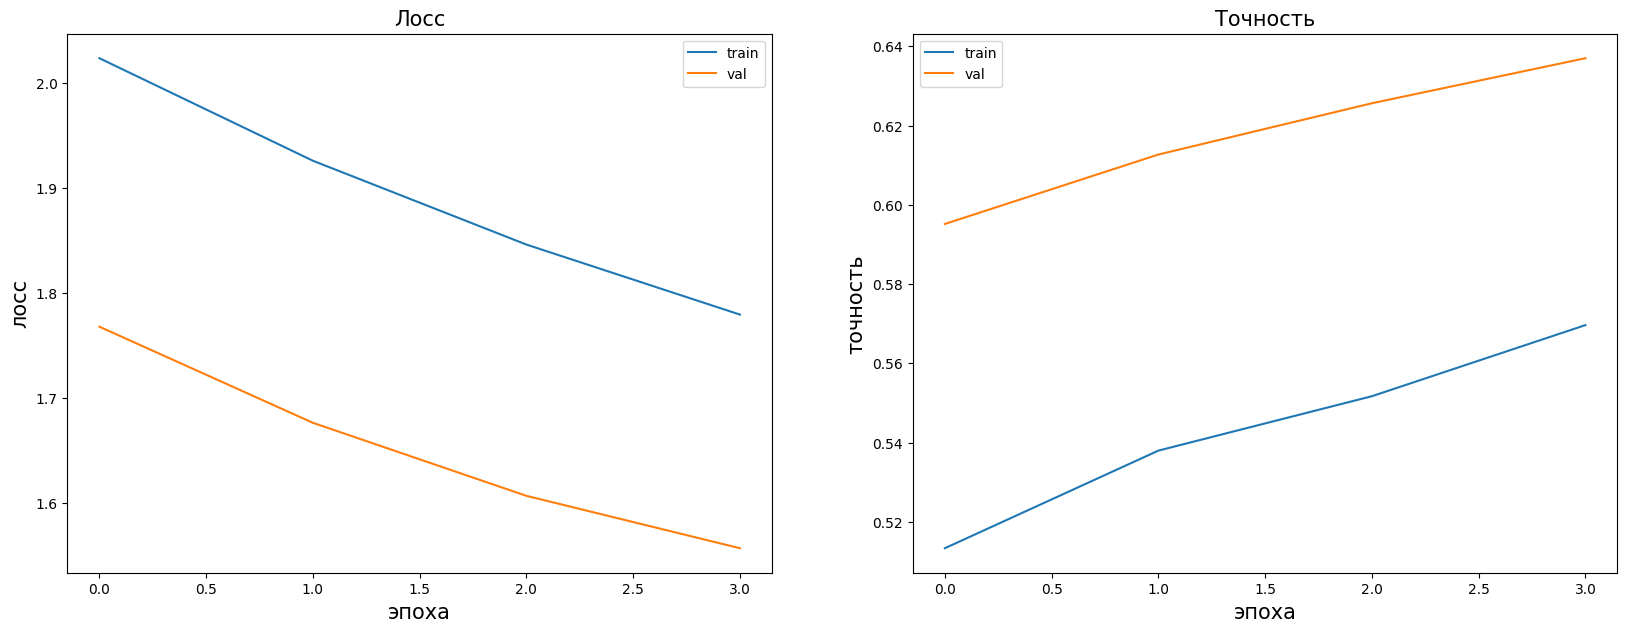

In [44]:
scheduler = StepLR(optimizer, step_size=2, gamma=0.9)

clf_model, history = train(
    fe_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=4, scheduler
)

## Подбор плохих аугментаций

In [40]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size, scale=(0.01, 0.02)),
    # transforms.CenterCrop(input_size),
    transforms.ColorJitter(1, 1, 1),
    transforms.Grayscale(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [17]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=4, ncols=5, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

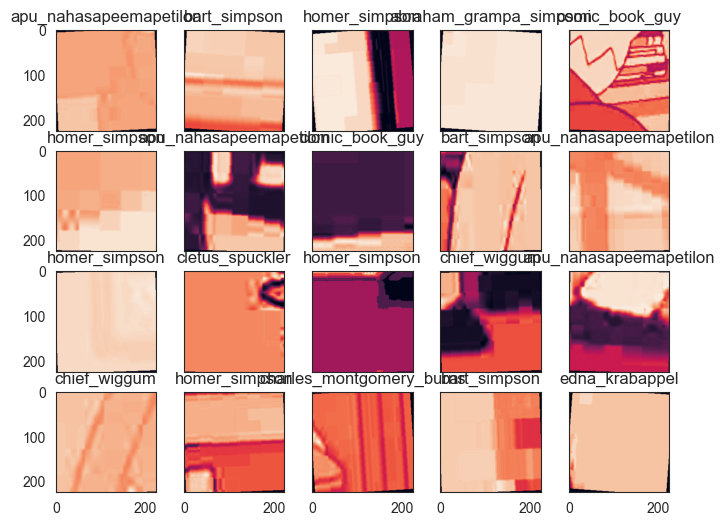

In [41]:
show_images(train_dataset)

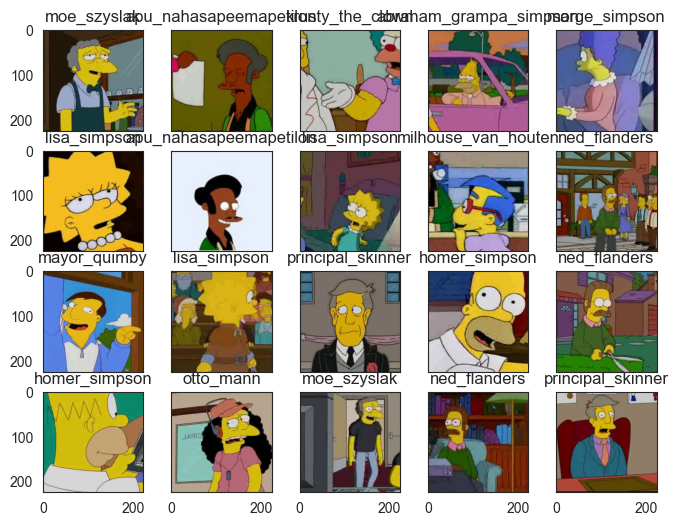

In [39]:
show_images(val_dataset)

Epoch 10 of 10 took 144.089s
  training loss (in-iteration): 	0.095604
  validation loss (in-iteration): 	0.210664
  training accuracy: 			97.75 %
  validation accuracy: 			95.08 %


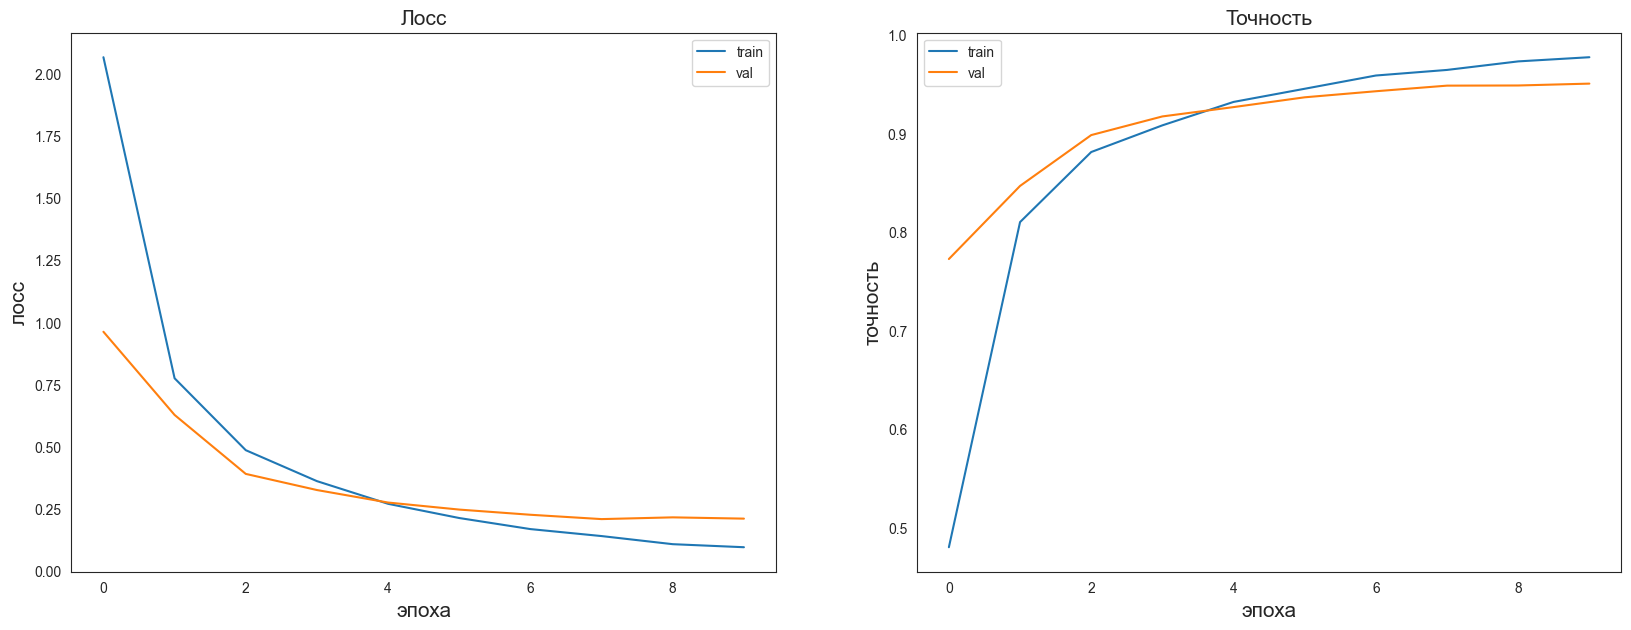

In [54]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(weights=ResNet18_Weights.DEFAULT))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

Добиться сильного ухудшения точности даже благодаря таким, казалось бы, радикальным аугментациям, не удалось.

## Применение MobileNet

Приведем в порядок train датасет

In [44]:
train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

### Обучение с нуля

Epoch 10 of 10 took 91.786s
  training loss (in-iteration): 	2.782357
  validation loss (in-iteration): 	2.614560
  training accuracy: 			20.25 %
  validation accuracy: 			24.40 %


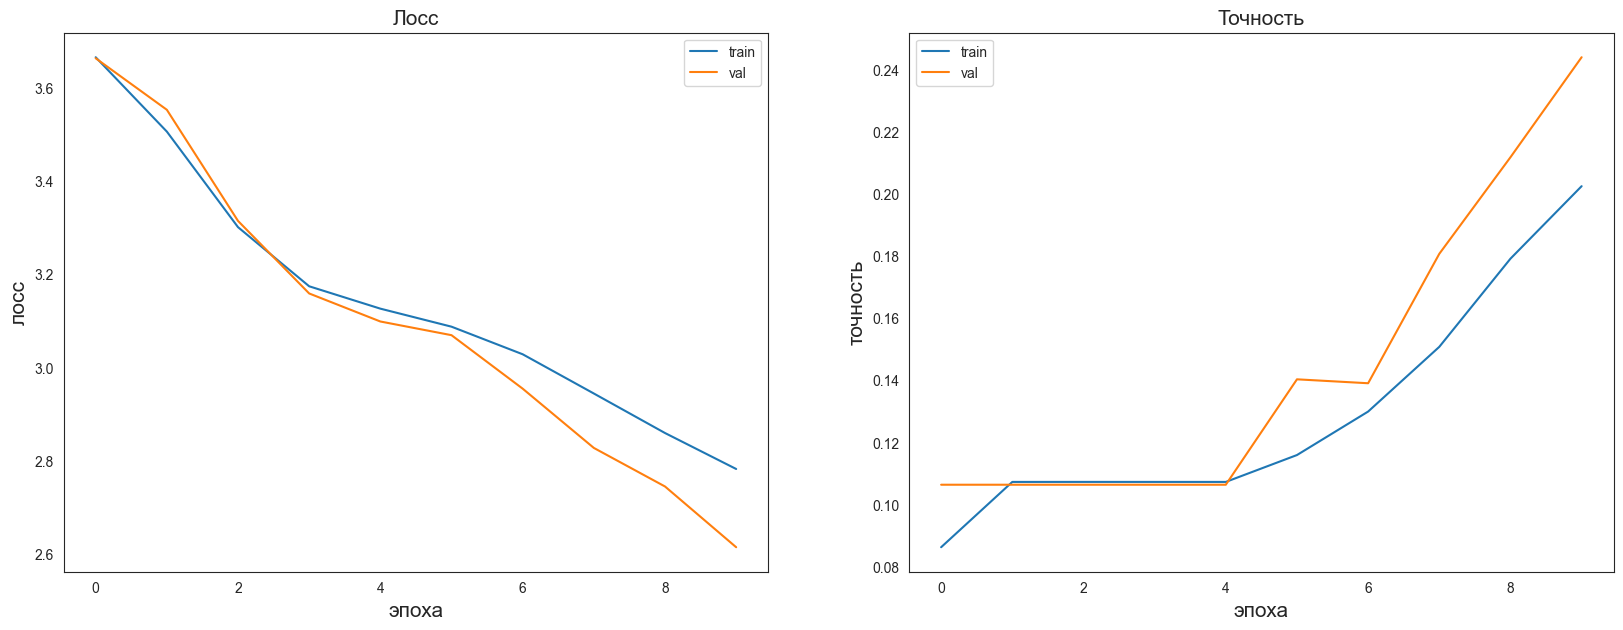

In [49]:
model = mobilenet_v3_small()
model.classifier[3] = nn.Linear(in_features=1024, out_features=42, bias=True)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

### Использование как Feature Extractor

Epoch 10 of 10 took 64.844s
  training loss (in-iteration): 	1.608860
  validation loss (in-iteration): 	1.324479
  training accuracy: 			60.39 %
  validation accuracy: 			68.69 %


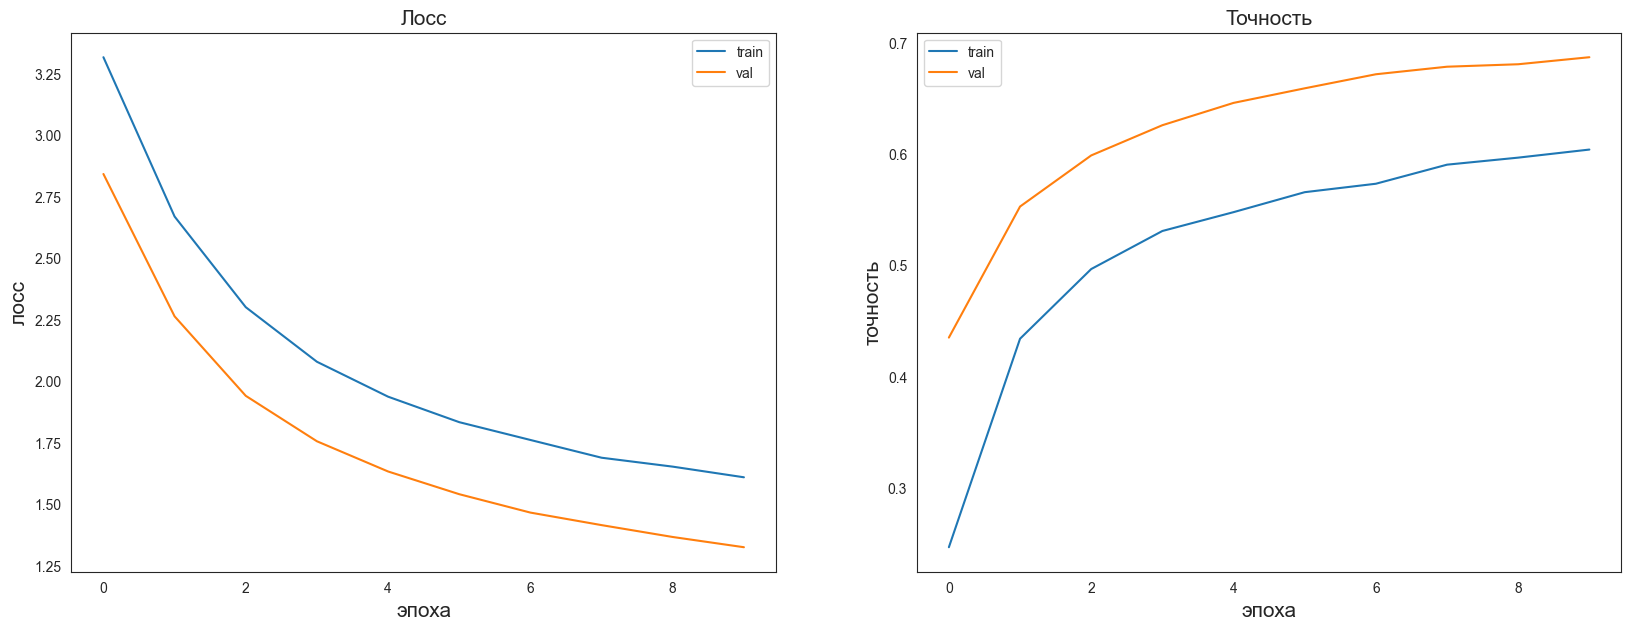

In [50]:
# возьмём предобученную сеть
fe_model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.classifier[3] = nn.Linear(in_features=1024, out_features=42, bias=True)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

### Использование для FineTuning

Epoch 10 of 10 took 92.286s
  training loss (in-iteration): 	0.270196
  validation loss (in-iteration): 	0.273467
  training accuracy: 			92.79 %
  validation accuracy: 			92.58 %


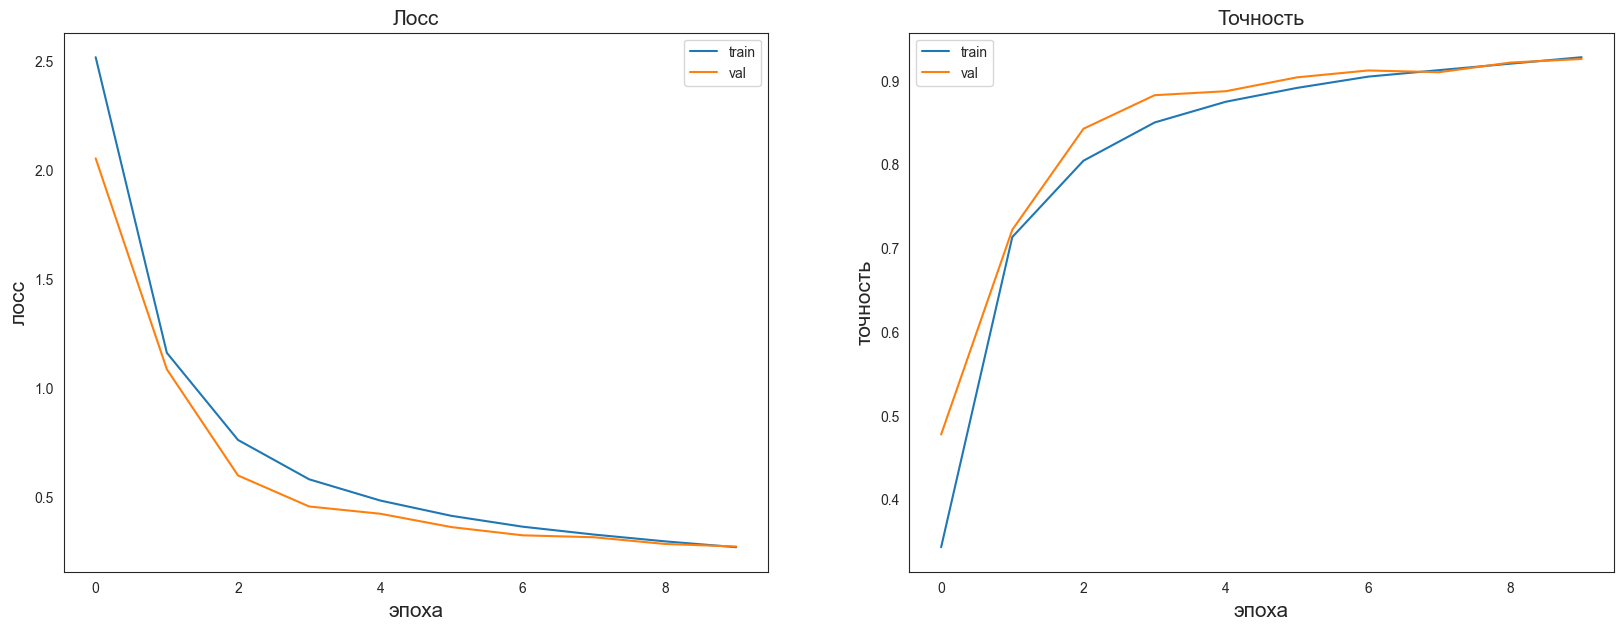

In [51]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('mobilenet', mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=10
)

## Выводы

Использование mobilenet показало аналогичные, как на занятии, результаты:
- обучение с нуля идёт хорошо, за 10 эпох тенденция положителная, точность растёт. Видимо потому, что архитектура сети отлично подходит для классификации изображений
- использование как feature extractor выводит на плато по точности в районе 79%. Видимо потому, что сеть обучалась на датасете imagenet, а он отличается от кадров из мультфильма
- использование для fine tuning уже за 10 эпох дает точность 92.58% и есть тенденция к росту.